# Basic clustering approaches

Let's try to cluster our waterbodies using vectorial methods.

## Setup

### Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.optimize as opt
import matplotlib.colors
import matplotlib.patches
from tqdm.notebook import tqdm
import sklearn.cluster
import sklearn.decomposition
import scipy.ndimage.filters
import scipy.cluster
import matplotlib.animation
import datacube

import sys
sys.path.insert(1, '../Scripts')
import dea_plotting

%matplotlib widget

### Load the data

This was generated in WaterbodyClustering.ipynb.

In [2]:
history = np.load('history_murray_full_norivers.npy')
times = np.load('time_axis_murray_full_norivers.npy').astype('datetime64[D]')
waterbodies = gpd.read_file('waterbodies_murray_norivers.geojson')

We'll be clustering using slightly blurred versions of the most recent five years of water history.

In [3]:
data = history[:, -365 * 5:]
times_ = times[-365 * 5:]

In [4]:
data = scipy.ndimage.filters.gaussian_filter1d(data, sigma=7, axis=1)

In [5]:
data /= 100

In [6]:
data = np.diff(data)

In [7]:
times_ = times_[1:]

In [8]:
mean = data.mean(axis=0)

In [9]:
plt.figure()
plt.plot(times_, mean)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Agglomerative clustering

Agglomerative clustering doesn't require a number of clusters, so we can try using that to cluster our data without a priori knowledge of how many clusters we should have. We'll use average linkage.

In [9]:
linkage = scipy.cluster.hierarchy.linkage(data, method='average')

In [10]:
plt.figure()
scipy.cluster.hierarchy.dendrogram(linkage, p=5, truncate_mode='level', orientation='right', show_contracted=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can then investigate these clusters! How many clusters do we need to have to get a reasonable split?

In [11]:
clusters_ = [scipy.cluster.hierarchy.fcluster(linkage, k, criterion='maxclust') for k in range(100)]

In [12]:
plt.figure()
bins = np.arange(len(clusters_)) + 1
hists = []
for k in range(len(clusters_)):
    hists.append(np.histogram(clusters_[k], bins=bins)[0])
plt.imshow(np.array(hists) + 1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The biggest split is the very final one (obviously) but there are no other particularly strong splits until 50+ clusters. What makes this particular split so important?

In [13]:
plt.figure()
plt.hist(clusters_[3])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([   7.,    0.,    0.,    0.,    0., 6720.,    0.,    0.,    0.,
        2354.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

In [14]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(times_, data[clusters_[3] == 2].mean(axis=0))
plt.plot(times_, data[clusters_[3] == 3].mean(axis=0))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Wow, it's things that are not very full vs things that are. This is not useful! Maybe if we instead first divide out by the total amount of water over all time? Average linkage works *terribly* in this case for some reason (very similar to single linkage) so we will use Ward.

In [15]:
data_normalised = data / (data.sum(axis=1, keepdims=True) + 1)

In [16]:
linkage = scipy.cluster.hierarchy.linkage(data_normalised, method='ward')

In [17]:
plt.figure()
scipy.cluster.hierarchy.dendrogram(linkage, p=5, truncate_mode='level', orientation='right', show_contracted=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
clusters_ = [scipy.cluster.hierarchy.fcluster(linkage, k, criterion='maxclust') for k in range(100)]

In [ ]:
plt.figure()
bins = np.arange(len(clusters_)) + 1
hists = []
for k in range(len(clusters_)):
    hists.append(np.histogram(clusters_[k], bins=bins)[0])
plt.imshow(np.array(hists) + 1)

This actually looks pretty good! Let's cut at 2.

In [20]:
plt.figure()
plt.hist(clusters_[2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([7367.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1714.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <a list of 10 Patch objects>)

In [62]:
plt.figure()
plt.plot(times_, data[clusters_[2] == 1].mean(axis=0))
plt.plot(times_, data[clusters_[2] == 2].mean(axis=0))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We have things that ebb and flow pretty normally, and things that just spiked really, really strongly in the 2016 La Nino. What kind of things are in each class?

In [60]:
import datacube

dc = datacube.Datacube(app='clustering')

In [24]:
np.random.seed(0)

cluster_2_sample = np.random.choice((clusters_[2] == 2).nonzero()[0], size=9, replace=False)

In [61]:
def cluster_sample(cluster_mask):
    das_1 = []
    cluster_1_sample = np.random.choice(cluster_mask.nonzero()[0], size=9, replace=False)
    for k in cluster_1_sample:
        waterbody = waterbodies.iloc[k]
        da = dc.load('ls8_nbart_geomedian_annual', measurements=['red', 'green', 'blue'],
                     geopolygon=datacube.utils.geometry.Geometry(waterbody.geometry.buffer(1500), crs='EPSG:3577'), time='2019-01')
        das_1.append(da.isel(time=0))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        dea_plotting.rgb(das_1[i], bands=['red', 'green', 'blue'], ax=ax)
        geometry = waterbodies.iloc[cluster_1_sample[i]].geometry
        patch = matplotlib.patches.Polygon(geometry.exterior, edgecolor='white', facecolor='#AAAAFF55')
        ax.add_patch(patch)
        ax.set_title('')
        ax.axis('off')
        ys = data[cluster_1_sample[i]]
        ys = ys / max(ys) * 0.5
        xs = np.linspace(0, 1, len(ys))
        points = np.stack([xs, ys]).T
        tf_sp = ax.transData.inverted().transform(ax.transAxes.transform(points))
        plt.plot(tf_sp[:, 0], tf_sp[:, 1], c='white')

In [164]:
cluster_sample(clusters_[2] == 1)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

These don't look very meaningful :( Let's try K-means clustering.

In [64]:
km = sklearn.cluster.KMeans(n_clusters=2)

In [167]:
clusters = km.fit_predict(data_normalised)

In [168]:
plt.figure()
plt.plot(km.cluster_centers_.T)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

K-means finds the exact same clusters!

In [169]:
cluster_sample(clusters == 0)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [171]:
cluster_sample(clusters == 1)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

This looks pretty good! These seem to be La Nina spikes.

## Clustering based on the autocorrelation function

Let's compute the autocorrelation functions of these data and see if K-means works better on those.

In [26]:
import statsmodels.tsa.stattools

In [84]:
acfs = [statsmodels.tsa.stattools.acf(x, fft=True, nlags=28) for x in tqdm(data)]
acfs_grad = [statsmodels.tsa.stattools.acf(np.gradient(x), fft=True, nlags=28) for x in tqdm(data)]

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:578: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


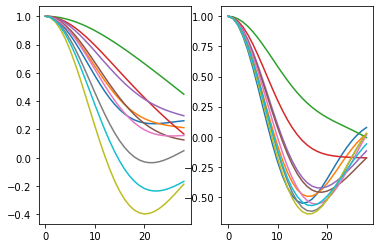

In [85]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(np.transpose(acfs[:10]));
plt.subplot(1, 2, 2)
plt.plot(np.transpose(acfs_grad[:10]));
plt.show()

In [86]:
acfs = np.array(acfs)
acfs_grad = np.array(acfs_grad)

Now let's cluster these.

In [74]:
kmc_acf = sklearn.cluster.KMeans(n_clusters=8)

In [75]:
clusters_acf = kmc_acf.fit_predict(np.nan_to_num(acfs))

(array([ 830.,  506., 1414.,  300., 1741.,  985., 1626., 1679.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

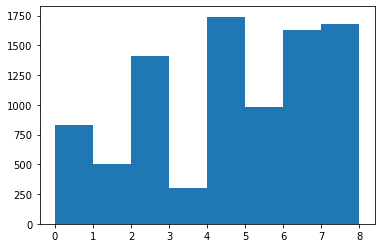

In [76]:
plt.figure()
plt.hist(clusters_acf, bins=range(9))

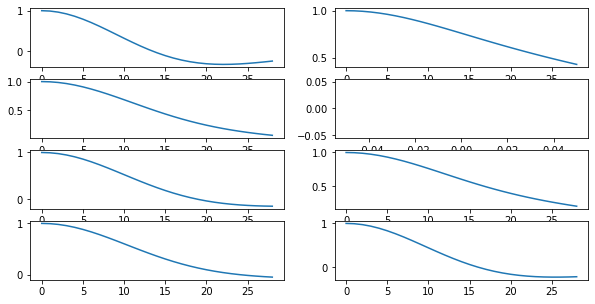

In [77]:
%matplotlib inline
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(4, 2, i + 1)
    plt.plot(np.array(acfs)[clusters_acf == i].mean(axis=0))

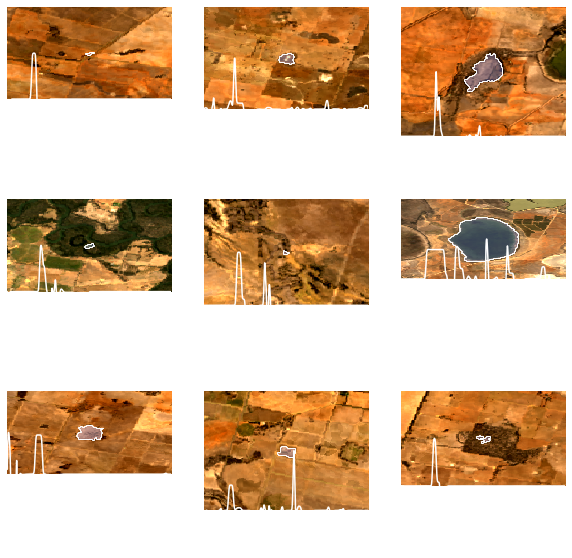

In [78]:
cluster_sample(clusters_acf == 1)

In [79]:
tsne = sklearn.manifold.TSNE()

In [82]:
tsne_f = tsne.fit_transform(np.nan_to_num(acfs))

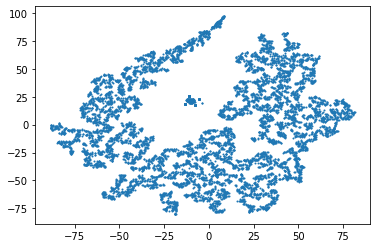

In [83]:
plt.figure()
plt.scatter(*tsne_f.T, s=1)